In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy
from collections import defaultdict
import json
import warnings
import glob
import os
import re
from functools import partial

import h5py
from joblib import Parallel, delayed
import k3d
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import yaml

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hd5fu9k_ because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = 0.5

            colors = k3d.helpers.map_colors(
                samples_distances, k3d.colormaps.matplotlib_color_maps.coolwarm_r, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [27]:
datafiles = glob.glob(
    os.path.join('/logs/whole_images/predictions/abc_0022_00221312_0cdd179f2b755db6d27ea303_001_32x32/predictions/', '*.npy')
)

In [28]:
def get_num(basename):
    match = re.match('^test_(\d+)\.npy$', basename)
    return int(match.groups()[0])

In [29]:
datafiles.sort(key=lambda name: get_num(os.path.basename(name)))

In [30]:
patches = [
    {'distances': np.load(f)}
    for f in datafiles
]

In [31]:
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
import sharpf.utils.abc_utils.hdf5.io_struct as io

In [35]:
PredictionsIO = io.HDF5IO({
    'distances': io.Float64('distances'),
},
len_label='distances',
compression='lzf')

In [36]:
def save_predictions(patches, filename):
    # turn a list of dicts into a dict of torch tensors:
    # default_collate([{'a': 'str1', 'x': np.random.normal()}, {'a': 'str2', 'x': np.random.normal()}])
    # Out[26]: {'a': ['str1', 'str2'], 'x': tensor([0.4252, 0.1414], dtype=torch.float64)}
    collate_fn = partial(io.collate_mapping_with_io, io=PredictionsIO)
    patches = collate_fn(patches)
    
    with h5py.File(filename, 'w') as f:
        PredictionsIO.write(f, 'distances', patches['distances'])

In [37]:
save_predictions(
    patches,
    os.path.join('/logs/whole_images/predictions/abc_0022_00221312_0cdd179f2b755db6d27ea303_001_32x32/predictions', 'test_predictions_0.hdf5'))

In [55]:
save_predictions(patches[16384:], os.path.join('/logs/baseline-image-predictions/predictions/', 'train_1.hdf5'))

In [38]:
def convert_npylist_to_hdf5(input_dir, output_dir):
    datafiles = glob.glob(os.path.join(input_dir, '*.npy'))
    datafiles.sort(key=lambda name: get_num(os.path.basename(name)))
    
    patches = [{'distances': np.load(f)} for f in datafiles]
    
    PredictionsIO = io.HDF5IO({
        'distances': io.Float64('distances'),
        },
        len_label='distances',
        compression='lzf')
    save_predictions(patches, os.path.join(output_dir, 'test_predictions_0.hdf5'))

In [39]:
input_root_dir = '/logs/whole_images/predictions/'
for d in glob.glob(os.path.join(input_root_dir, '*')):
    input_dir = os.path.join(d, 'predictions')
    output_dir = os.path.join(d, 'predictions')
    convert_npylist_to_hdf5(input_dir, output_dir)
    print(input_dir)

/logs/whole_images/predictions/abc_0022_00221312_0cdd179f2b755db6d27ea303_001_32x32/predictions


In [15]:
WholePointCloudIO = io.HDF5IO({
    'points': io.VarFloat64('points'),
    'normals': io.VarFloat64('normals'),
    'distances': io.VarFloat64('distances'),
    'directions': io.VarFloat64('directions'),
    'indexes_in_whole': io.VarInt32('indexes_in_whole'),
    'item_id': io.AsciiString('item_id'),
    'orig_vert_indices': io.VarInt32('orig_vert_indices'),
    'orig_face_indexes': io.VarInt32('orig_face_indexes'),
    'has_sharp': io.Bool('has_sharp'),
    'num_sharp_curves': io.Int8('num_sharp_curves'),
    'num_surfaces': io.Int8('num_surfaces'),
    'has_smell_coarse_surfaces_by_num_faces': io.Bool('has_smell_coarse_surfaces_by_num_faces'),
    'has_smell_coarse_surfaces_by_angles': io.Bool('has_smell_coarse_surfaces_by_angles'),
    'has_smell_deviating_resolution': io.Bool('has_smell_deviating_resolution'),
    'has_smell_sharpness_discontinuities': io.Bool('has_smell_sharpness_discontinuities'),
    'has_smell_bad_face_sampling': io.Bool('has_smell_bad_face_sampling'),
    'has_smell_mismatching_surface_annotation': io.Bool('has_smell_mismatching_surface_annotation'),
},
len_label='has_sharp',
compression='lzf')

In [16]:
dataset = Hdf5File('/logs/whole_00000058_666139e3bff64d4e8a6ce183_007.hdf5',
                   io=WholePointCloudIO,
                   preload=PreloadTypes.LAZY,
                   labels='*')

In [26]:
ground_truth = [patch for patch in dataset]

In [23]:
idx = np.random.randint(len(dataset))

patch = dataset[idx]

display_sharpness(None, plot_meshvert=False, meshvert_psize=0.01,
                  samples=patch['points'].reshape((-1, 3)), samples_distances=patch['distances'],
                  samples_color=0x0000ff, samples_psize=0.03,
                  directions=patch['directions'].reshape((-1, 3)))

Vectors(colors=array([], dtype=uint32), head_color=255, id=140632896413032, line_width=0.0025, model_matrix=array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32), origin_color=255, origins=array([[-1.1771371 ,  5.0430923 ,  0.95777905],
       [-1.4035254 ,  4.9713063 ,  0.74531245],
       [-1.4096197 ,  5.553408  ,  0.3806929 ],
       ...,
       [-1.3656868 ,  5.4095035 ,  0.5164818 ],
       [-1.1793903 ,  5.475799  ,  0.86218834],
       [-0.88081044,  5.287148  ,  1.165706  ]], dtype=float32), type='Vectors', vectors=array([[ 4.38009873e-02,  5.69069646e-02, -3.75263914e-02],
       [-6.62795678e-02, -7.58058205e-02,  3.98790501e-02],
       [-9.43520921e-04,  4.46590751e-01,  2.06651734e-04],
       ...,
       [ 2.97393388e-04, -3.09502542e-01, -1.04794635e-04],
       [-6.93584161e-06, -3.75798166e-01,  4.59753255e-06],
       [ 5.55561332e-04, -1.87147081e-01, -7.84820702e-04]], dtype=float32))


Output()

In [53]:
from collections import defaultdict

def combine_predictions(predictions, patches):
    n_points = np.concatenate([
        patch['indexes_in_whole']
        for patch in patches]).max() + 1
    
    whole_model_points_pred = np.zeros((n_points, 3))
    whole_model_distances_pred = np.ones(n_points) * np.inf
    whole_model_distances_gt = np.ones(n_points) * np.inf

    d = defaultdict(list)
    for prediction, patch in tqdm(zip(predictions, patches)):
        distances = prediction['distances']
        indexes = patch['indexes_in_whole']
        whole_model_points_pred[indexes] = patch['points'].reshape((-1, 3))

#         assign_mask = whole_model_distances_pred[indexes] > distances
#         whole_model_distances_pred[indexes[assign_mask]] = np.minimum(distances[assign_mask], 1.0)
        for i, idx in enumerate(indexes):
            d[idx].append(distances[i])

        whole_model_distances_gt[indexes] = distances
    
    for idx, values in d.items():
        whole_model_distances_pred[idx] = np.median(values)
        
    return whole_model_points_pred, whole_model_distances_pred, whole_model_distances_gt, d

In [54]:
whole_model_points_pred, whole_model_distances_pred, whole_model_distances_gt, d = combine_predictions(patches, ground_truth)

1101it [00:06, 176.43it/s]


In [55]:
display_sharpness(None, plot_meshvert=False, meshvert_psize=0.01,
                  samples=whole_model_points_pred,
                  samples_distances=whole_model_distances_pred,
                  samples_color=0x0000ff, samples_psize=0.03)

Output()

## Range-image business below

In [47]:

DepthMapIO = io.HDF5IO({
    'image': io.Float64('image'),
    'normals': io.Float64('normals'),
    'distances': io.Float64('distances'),
    'directions': io.Float64('directions'),
    'item_id': io.AsciiString('item_id'),
    'orig_vert_indices': io.VarInt32('orig_vert_indices'),
    'orig_face_indexes': io.VarInt32('orig_face_indexes'),
    'has_sharp': io.Bool('has_sharp'),
    'num_sharp_curves': io.Int8('num_sharp_curves'),
    'num_surfaces': io.Int8('num_surfaces'),
    'camera_pose': io.Float64('camera_pose'),
    'mesh_scale': io.Float64('mesh_scale'),
    'has_smell_coarse_surfaces_by_num_faces': io.Bool('has_smell_coarse_surfaces_by_num_faces'),
    'has_smell_coarse_surfaces_by_angles': io.Bool('has_smell_coarse_surfaces_by_angles'),
    'has_smell_deviating_resolution': io.Bool('has_smell_deviating_resolution'),
    'has_smell_sharpness_discontinuities': io.Bool('has_smell_sharpness_discontinuities'),
    'has_smell_bad_face_sampling': io.Bool('has_smell_bad_face_sampling'),
    'has_smell_mismatching_surface_annotation': io.Bool('has_smell_mismatching_surface_annotation'),
    'has_smell_raycasting_background': io.Bool('has_smell_raycasting_background'),
    'has_smell_depth_discontinuity': io.Bool('has_smell_depth_discontinuity'),
    'has_smell_mesh_self_intersections': io.Bool('has_smell_mesh_self_intersections'),
},
len_label='has_sharp',
compression='lzf')


In [56]:
predictions = Hdf5File(os.path.join('/logs/baseline-image-predictions/predictions/', 'train_0.hdf5'),
                   io=PredictionsIO,
                   preload=PreloadTypes.LAZY,
                   labels=['distances'])

In [57]:
predictions[0]

{'distances': array([[0.99973714, 0.99972999, 0.99975073, ..., 0.99974805, 0.9997434 ,
         0.99975163],
        [0.99973071, 0.99973589, 0.999749  , ..., 0.99975079, 0.99975276,
         0.99974746],
        [0.99973089, 0.99972665, 0.99973828, ..., 0.99975896, 0.99975002,
         0.99975771],
        ...,
        [0.99975735, 0.99976063, 0.99974817, ..., 0.99974597, 0.99974418,
         0.99975371],
        [0.99976039, 0.99974757, 0.99974734, ..., 0.99974495, 0.99974656,
         0.99976104],
        [0.99976128, 0.99975652, 0.99974781, ..., 0.99976695, 0.99976295,
         0.99976122]])}

In [48]:
ground_truth = Hdf5File(os.path.join('/logs/baseline-image-predictions/', 'train_0.hdf5'),
                   io=DepthMapIO,
                   preload=PreloadTypes.LAZY,
                   labels='*')

In [49]:
ground_truth[0]

{'has_sharp': False,
 'directions': array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]),
 'has_smell_depth_di

In [59]:
predictions[0]['distances'] - ground_truth[0]['distances']

array([[-0.00026286, -0.00027001, -0.00024927, ..., -0.00025195,
        -0.0002566 , -0.00024837],
       [-0.00026929, -0.00026411, -0.000251  , ..., -0.00024921,
        -0.00024724, -0.00025254],
       [-0.00026911, -0.00027335, -0.00026172, ..., -0.00024104,
        -0.00024998, -0.00024229],
       ...,
       [-0.00024265, -0.00023937, -0.00025183, ..., -0.00025403,
        -0.00025582, -0.00024629],
       [-0.00023961, -0.00025243, -0.00025266, ..., -0.00025505,
        -0.00025344, -0.00023896],
       [-0.00023872, -0.00024348, -0.00025219, ..., -0.00023305,
        -0.00023705, -0.00023878]])

In [80]:
from collections import Callable, Mapping
from copy import deepcopy
from typing import Tuple, MutableMapping

import numpy as np


class Metric(Callable):
    def __call__(self, true_instance, pred_label):
        pass


class PointwiseSquaredError(Metric):
    """Points with error above threshold are considered bad."""
    def __call__(self, true_instance, pred_label):
        true_distances = true_instance['distances']
        pred_distances = pred_label['distances']
        diff_sq = np.square(true_distances - pred_distances)
        return diff_sq


class RMSE(Metric):
    def __call__(self, true_instance, pred_label):
        diff_sq = PointwiseSquaredError()(true_instance, pred_label)
        return np.sqrt(
            np.mean(diff_sq))


class BadPoints(Metric):
    """Points with error above threshold are considered bad."""
    def __init__(self, threshold):
        self._threshold_sq = threshold ** 2

    def __call__(self, true_instance, pred_label):
        diff_sq = PointwiseSquaredError()(true_instance, pred_label)
        return np.sum(diff_sq > self._threshold_sq)


class PointwiseMaskSelector(Callable):
    def __call__(self, true_instance: MutableMapping, pred_label: MutableMapping) \
            -> Tuple[MutableMapping, MutableMapping]:
        pass


class DistanceLessThan(PointwiseMaskSelector):
    def __init__(self, threshold):
        self._threshold = threshold

    def __call__(self, true_instance, pred_label):
        masked_true_instance = deepcopy(true_instance)
        true_distances = masked_true_instance['distances']
        selection_mask = true_distances < self._threshold
        masked_true_instance['distances'] = true_distances[selection_mask]

        masked_pred_label = deepcopy(pred_label)
        pred_distances = masked_pred_label['distances']
        masked_pred_label['distances'] = pred_distances[selection_mask]
        return masked_true_instance, masked_pred_label


In [69]:
mask_selector = DistanceLessThan(1.0)


# RMSE = SquareRoot(Mean(PointwiseSquaredError()))

# metric = RMSE()

# metric(true_instance, pred_label)



In [74]:
# true_instance, pred_label = mask_selector(ground_truth[0], predictions[0])
true_instance, pred_label = ground_truth[0], predictions[0]

In [77]:
rmse = RMSE()

In [78]:
rmse(true_instance, pred_label)

0.0002433365716020843

In [91]:
bad_points = BadPoints(0.0001)

In [92]:
bad_points(true_instance, pred_label)

4096

In [88]:
poinwise_sqe = PointwiseSquaredError()

In [90]:
poinwise_sqe(true_instance, pred_label)

8.460574463242665e-08

In [110]:
rmse = RMSE()
bad_points = BadPoints(0.1)

n_instances = len(ground_truth)

rmse_values = np.zeros(n_instances)
bad_points_values = np.zeros(n_instances)

for idx in tqdm(range(n_instances)):
    true_instance, pred_label = ground_truth[idx], predictions[idx]
    rmse_values[idx] = rmse(true_instance, pred_label)
    bad_points_values[idx] = bad_points(true_instance, pred_label)

100%|██████████| 16384/16384 [00:01<00:00, 11654.70it/s]


(0.0, 1.0)

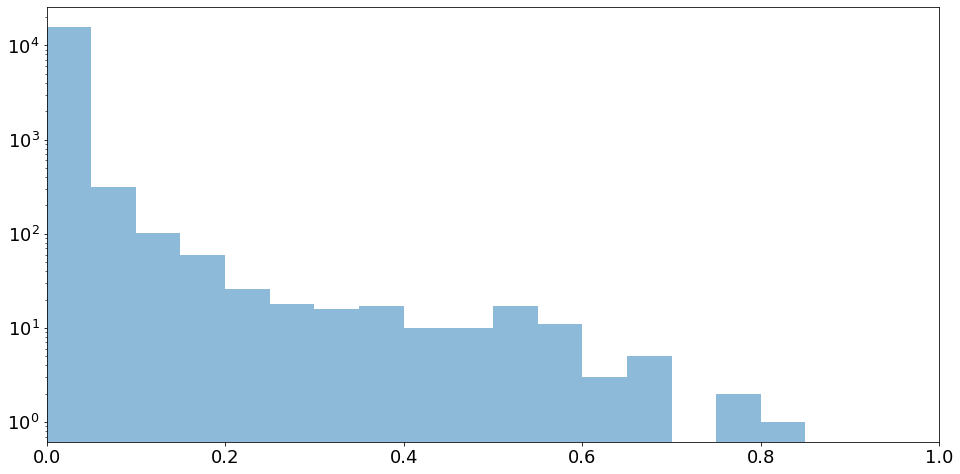

In [139]:
plt.figure(figsize=(16, 8))
_ = plt.hist(
    rmse_values,
    bins=np.linspace(0, 1, 21),
    range=[0, 1],
    log=True,
    histtype='stepfilled',
    alpha=0.5
)
plt.gca().tick_params(axis='both', which='both', labelsize=18)
plt.gca().set_xlim([0, 1])

(0.0, 4096.0)

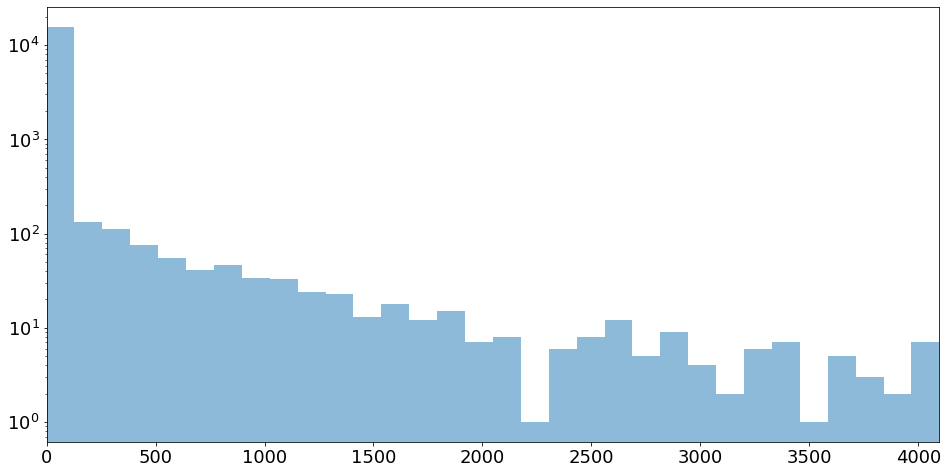

In [140]:
plt.figure(figsize=(16, 8))
_ = plt.hist(
    bad_points_values,
    bins=np.linspace(0, 4096, 33),
    range=[0, 4096],
    log=True,
    histtype='stepfilled',
    alpha=0.5
)
plt.gca().tick_params(axis='both', which='both', labelsize=18)
plt.gca().set_xlim([0, 4096])